# Force of Transmission

The goal of this notebook is to address a good point from **Reviewer 2**. The reviewer wants us to further explore whether this outbreak represents a situation where the 'force of infection' was higher than normal - i.e., that the boat represents a superspreading event where there are substantially more secondary infections than primary infections.

One measure of the 'force of infection' is the $R_0$; the average number of people who will contract a contagious disease from one person with that disease. We would expect that a superspreading event would have a higher $R_0$ than a normal transmission senario.

Therefore, if we can only explain the level of transmission on the boat in the time it was at sea with a higher than average $R_0$, we can support the notion that this was superspreading. 

To do this, I will use a simple model of pathogen transmission in a population called 'SEIR' that models the percentage of a population that is *susceptible, exposed, infected, or removed* over a period of time.

![SEIR](BasicSEIRS_compartments_padded.png)

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy.optimize import brentq, fminbound
from scipy.integrate import odeint

### Parameters for SARS-CoV-2 Infection

These parameters include the total number of people on the boat (`122`), the number of initial infections (assumed to be `1`), the number of days it takes after exposure to become infections (assuming [`~5` days](https://onlinelibrary.wiley.com/doi/abs/10.1002/jmv.26041)), and the number of days after becoming infections that you no longer shed virus (setting this to [`~8` days](https://www.nature.com/articles/s41467-020-20568-4)). 

In [2]:
## == Parameter Values == ##

# Days from exposed to infectious -- He et. al., 2020
days_latent = 5.08

# Number of days until recovery -- van Kampen et al., 2021
days_infectious = 8

# Number of crew
n_crew = 122

# Number of initial infections
n_index_cases = 1

# Number of days on the boat
days_at_sea = 16

# Percentage of the crew infected
perc_crew_infected = .8525

# Range of reproductive numbers to test
min_R0 = 1
max_R0 = 15

I'll use two models, a simple model that doesn't take into account the time between exposure and infectiousness, and a more complex model that does take into account latency. The code here is based on this super helpful [article](https://jckantor.github.io/CBE30338/03.09-COVID-19.html).

In [3]:
# SIR model differential equations.
def sir_deriv(x, t, beta, gamma):
    s, i, r = x
    dsdt = -beta * s * i
    didt = beta * s * i - gamma * i
    drdt =  gamma * i
    return [dsdt, didt, drdt]

# Basic SIR model.
def SIR(R0,
        gamma,
        initN, 
        max_time,
        initI = 1,
        initR = 0,
        intervals = 1000):
    """
    Define a simple function to model SIR
    over a set of R0s. 
    """
    
    # Calculate beta parameter from the provided R0 and gamma
    beta = R0*gamma
    # Timeunits to run the analysis
    t = np.linspace(0, max_time, intervals)
    # Fraction of the population infected, recovered, and suceptible
    i_initial = initI/initN
    r_initial = initR/initN
    s_initial = 1 - i_initial - r_initial
    
    # Integrate 
    x_initial = s_initial, i_initial, r_initial
    soln = odeint(sir_deriv, x_initial, t, args=(beta, gamma))

    return soln.T


# SEIR model differential equations.
def seir_deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


# Slightly more complex SEIR model.
def SEIR(R0,
         gamma,
         alpha,
         max_time,
         initN, 
         initI = 1,
         initR = 0,
         initE = 0,
         intervals = 1000):
    """
    Define a simple function to model SEIR
    over a set of R0s. 
    """
    
    # Calculate beta parameter from the provided R0 and gamma
    beta = R0*gamma
    
    # Timeunits to run the analysis
    t = np.linspace(0, max_time, intervals)
    
    # Fraction of the population infected, recovered, and suceptible
    i_initial = initI/initN
    r_initial = initR/initN
    e_initial = initE/initN
    s_initial = 1 - i_initial - r_initial - e_initial
    
    # Integrate 
    x_initial = s_initial, i_initial, r_initial, e_initial
    soln = odeint(seir_deriv, x_initial, t, args=(alpha, beta, gamma))

    return soln.T

In [4]:
## == Run the Models == ##
sir_percent_infected = dict()
seir_percent_infected = dict()

for R0 in np.linspace(min_R0, max_R0, num=50):
    
    # Run the SIR model
    s, i, r = SIR(R0 = R0,
        gamma=1/(days_latent + days_infectious),
        initN=n_crew, 
        initI=n_index_cases,
        max_time=days_at_sea,
        intervals = 1000)
    
    sir_percent_infected[round(R0, 2)] = 1 - s[-1]

    # Run the SEIR model
    s, e, i, r = SEIR(R0 = R0,
        alpha=1/days_latent,
        gamma=1/days_infectious,
        initN=n_crew, 
        initI=n_index_cases,
        max_time=days_at_sea,
        intervals = 1000)
    
    seir_percent_infected[round(R0, 2)] = 1 - s[-1]

sir_df = pd.DataFrame.from_dict(sir_percent_infected.items())
sir_df.columns = ['R_0', 'I + E + R']

seir_df = pd.DataFrame.from_dict(seir_percent_infected.items())
seir_df.columns = ['R_0', 'I + E + R']

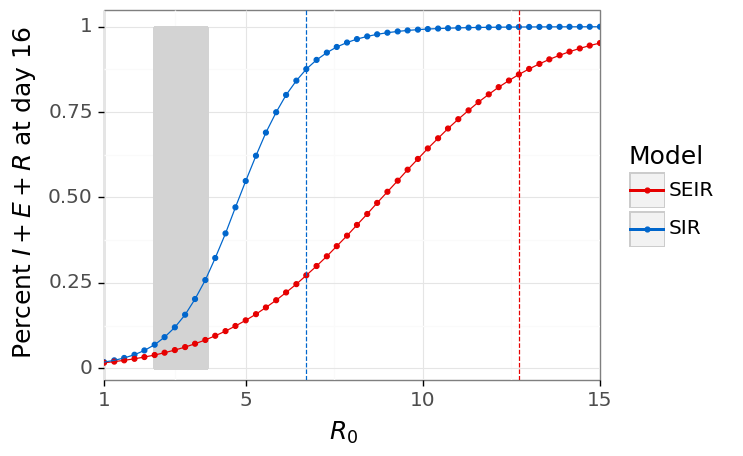

<ggplot: (8770437960345)>

In [5]:
## == Plot them together == ##

sir_df['Model'] = "SIR"
seir_df['Model'] = "SEIR"

sir_R0 = min(sir_df[sir_df['I + E + R'] >= perc_crew_infected].R_0)
seir_R0 = min(seir_df[seir_df['I + E + R'] >= perc_crew_infected].R_0)

# 95% CI for Reproduction number in 2020.-- He et. al., 2020
R_0_range_95CI = [2.41, 3.90]

model_plot = (
ggplot(pd.concat([sir_df, seir_df]), aes('R_0', 'I + E + R'))
 + geom_rect(xmin=R_0_range_95CI[0], xmax=R_0_range_95CI[1], ymin=0, ymax=1, alpha=0.05, fill="lightgrey", colour ="lightgrey")
 + geom_point(aes(colour = 'Model'))
 + geom_line(aes(colour = 'Model'))
 + geom_vline(xintercept = sir_R0, colour="#0066cc", linetype='dashed')
 + geom_vline(xintercept = seir_R0, colour="#e60000", linetype='dashed')
 + scale_x_continuous(breaks=(1, 5, 10, 15), expand=(0, 0))
 + scale_y_continuous(breaks=(0, .25, .5, .75, 1))
 + scale_color_manual(values=("#e60000", "#0066cc"))
 + xlab("$R_0$")
 + ylab("Percent $I + E + R$ at day 16")
 + theme_bw(18)
)

model_plot


In [6]:
print(f"The minimum R0 for the SIR model is: {sir_R0}")
print(f"The minimum R0 for the SEIR model is: {seir_R0}")

The minimum R0 for the SIR model is: 6.71
The minimum R0 for the SEIR model is: 12.71


In [7]:
model_plot.save(filename = '../../results/figures/basic-reproduction-number.svg', height=5, width=7, units = 'in', dpi=300)

/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 5 in image.
/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../results/figures/basic-reproduction-number.svg


With both models, the number of people infected on the boat given the amount of time at sea would have had to result from a substantially higher $R_0$ than is usually calculated for SARS-CoV-2. The normal range for SARS-CoV-2 $R_0$ is highlighed in the plot in gray. The $R_0$ at which we would expect ~85% of the boat to become infected is indicated with a dotted line. 